## Predict Ethereum price using Recurrent Neural Networks (LSTM)

In [1]:
# Import neccessary packages
import numpy as np 
import pandas as pd 
import math
import seaborn as sns

from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler 
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping 
from keras.models import load_model

from keras.backend import clear_session

import warnings
warnings.filterwarnings("ignore")

##### First of all, I define some functions we are going to use.

In [2]:
def partition_dataset(window_length, data, index_target):
    """
    The LSTM needs data with the format of [samples, time steps, features], 
    so we create N samples, window_length time steps per sample, and number of features
    """
    x, y = [], []
    data_len = data.shape[0]
    for i in range(window_length, data_len):
        x.append(data[i-window_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_target]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

In [3]:
def regression_metrics(y_test, y_pred):
    
    """
    Define evaluation metrics for regression problem
    Parameters: y_test: true values
                y_pred: predicted values
    """
    
    print('R2 Score: ', r2_score(y_test, y_pred))
    print('Mean Absolute Error: ', mean_absolute_error(y_test, y_pred))
    print('Mean Squared Error: ', mean_squared_error(y_test, y_pred))
    MDAPE = np.mean((np.abs(np.subtract(y_test, y_pred)/ y_test)) ) * 100
    print(f'Mean Absolute Percentage Error: {np.round(MDAPE, 2)} %')

In [4]:
def history_accuracy_loss(history):

    """ Plot training & testing loss values """
    
    fig, ax = plt.subplots(figsize=(20, 10), sharex=True)
    plt.plot(history.history["loss"])
    plt.plot(history.history['val_loss'])
    plt.title("Model loss")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
    plt.legend(["Training", "Testing"], loc="upper left")
    plt.grid()
    plt.show()

In [5]:
def plot_actual_predicted(original, predictions, title):
     
    """ Visualize actual and predicted price """
    
    ax = sns.lineplot(x=original.index, y=original[0], label="Real Price", color='royalblue',linewidth=2)
    ax = sns.lineplot(x=predictions.index, y=predictions[0], label="Predicted Price", color='tomato',linewidth=2)
    ax.set_title(title, size = 20)
    ax.set_xlabel("Date", size = 16)
    ax.set_ylabel("Price (USD)", size = 16)
    ax.set_xticklabels('', size=16);
    plt.grid()
    set_size(10,5)

In [6]:
def set_size(w, h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)

### 1. Data loading

In [7]:
df = pd.read_csv('data/eth_clean.csv')
df.drop(columns='Unnamed: 0', inplace = True)
df

,date,PriceUSD,AdrActCnt,AdrBal1in100MCnt,AdrBal1in10BCnt,AdrBal1in10MCnt,AdrBal1in1BCnt,AdrBal1in1MCnt,CapMrktCurUSD,CapRealUSD,...,FlowOutExUSD,GasUsedTx,GasUsedTxMean,HashRate,RevHashNtv,RevHashRateNtv,RevHashRateUSD,SplyAdrBalUSD1M,TxCnt,TxTfrValMedUSD
0,2015-08-08,1.199990,1208,9958,10267,9550,10115,8111,8.676871e+07,1.500465e+07,...,1.698517e+04,376006093,130512.354391,0.096483,3.360253,290325.822770,348388.084065,1.661840e+07,2881,1.199990
1,2015-08-09,1.199990,1113,10043,10411,9573,10222,8091,8.680133e+07,1.778419e+07,...,1.127113e+05,38863003,29242.289691,0.101360,3.105048,268276.120316,321928.661618,1.682678e+07,1329,15.599147
2,2015-08-10,1.199990,1430,10145,10572,9611,10348,8101,8.683471e+07,1.878138e+07,...,2.135630e+05,74070061,36362.327442,0.111855,2.881582,248968.649994,298759.890307,1.720648e+07,2037,0.718002
3,2015-08-11,0.990000,2697,10188,10706,9614,10429,8081,7.166698e+07,1.869114e+07,...,1.752126e+05,163481740,32940.104775,0.124450,2.607691,225304.507322,223051.462249,1.551874e+07,4963,0.053993
4,2015-08-12,1.288000,1219,10296,10893,9654,10574,8105,9.327472e+07,1.983690e+07,...,1.891297e+05,70102332,34431.400786,0.130915,2.422720,209322.978321,269607.996077,1.851254e+07,2036,12.880000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2291,2021-11-15,4569.407770,606036,1166692,18202185,241239,5573039,36595,5.367033e+11,2.735353e+11,...,1.029855e+10,97422476367,75542.615410,817.739849,0.000213,18.400399,84078.925802,1.025092e+08,1289636,456.940777
2292,2021-11-16,4234.131465,609879,1165639,18237665,240967,5580973,36564,4.973249e+11,2.675504e+11,...,1.678261e+09,96356492010,73545.984332,793.794054,0.000219,18.962616,80290.211052,1.022489e+08,1310153,423.413146
2293,2021-11-17,4265.599006,695412,1167736,18217312,241192,5589438,36563,5.010266e+11,2.678047e+11,...,1.282525e+09,98477697827,72772.919850,830.259240,0.000207,17.849640,76139.406528,1.022624e+08,1353219,319.823949
2294,2021-11-18,3985.674373,591159,1170963,18239379,241438,5599347,36605,4.681491e+11,2.625782e+11,...,1.424465e+09,98258045079,76510.060408,851.155962,0.000203,17.527776,69860.008277,1.019504e+08,1284250,398.991334


### 2. Data Processing

In [8]:
def data_processing(df):
    # copy from raw data
    data = df.copy()

    # drop the timestamp columns as it is not used as a predictor
    data.drop(columns='date', inplace=True)

    # ensure all data is float
    data = data.astype(float)

    # normalize the dataset
    scaler = MinMaxScaler()
    np_data_scaled = scaler.fit_transform(data.values)

    # scale one feature for reversion purpose later
    scaler_pred = MinMaxScaler()
    df_PriceUSD = pd.DataFrame(data['PriceUSD'])
    np_PriceUSD_scaled = scaler_pred.fit_transform(df_PriceUSD)
    
    return data, scaler, scaler_pred, np_data_scaled

In [9]:
data, scaler, scaler_pred, np_data_scaled = data_processing(df)

### 3. Data Transformation

- The first 80% of the data is used in training the model, and the last 20% will be used to test the model.
- The RNN-LSTM needs data with the format of [samples, time steps, features], so let's transform data from [num rows x num features] to N samples, sequence_length time steps per sample, and number of features

In [10]:
def data_transformation(data, sequence_length, np_data_scaled, index_target):
    
    # Split the training data into train and train data sets
    train_data_len = math.ceil(np_data_scaled.shape[0] * 0.9)

    # Create the training and test data
    train_data = np_data_scaled[0:train_data_len, :]
    test_data = np_data_scaled[train_data_len - sequence_length:, :]

    # Generate training data and test data
    x_train, y_train = partition_dataset(sequence_length, train_data, index_target)
    x_test, y_test = partition_dataset(sequence_length, test_data, index_target)

    # Print the shapes:
    print('X_train shape: ', x_train.shape)
    print('y_train shape: ', y_train.shape)
    print('X_test shape: ', x_test.shape)
    print('y_test shape: ', y_test.shape)
    
    return x_train, y_train, x_test, y_test

In [11]:
# Data transformation
sequence_length = 7
x_train, y_train, x_test, y_test = data_transformation(data, sequence_length, np_data_scaled, data.columns.get_loc("PriceUSD"))

X_train shape:  (2060, 7, 24)
y_train shape:  (2060,)
X_test shape:  (229, 7, 24)
y_test shape:  (229,)


### 4. Creating the LSTM Model

Here I create two models for the testing purpose to see which one is better.

In [12]:
def model_1(x_train):
    
    """
    Model 1:
    - Two LSTM layers with number of neurons is window length * number of features, the input shape is (x_train.shape[1], x_train.shape[2])
    - One fully connect layer with 50 neurons
    - The final dense layer that outputs the predicted value
    - Adam Optimizer
    - Set the loss as the mean_squarred_error
    
    """
    # initial the model
    model = Sequential()

    # Model with n_neurons = window length * number of features
    n_neurons = x_train.shape[1] * x_train.shape[2]

    model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
    model.add(LSTM(n_neurons, return_sequences=False))
    model.add(Dense(50))
    model.add(Dense(1))

    # Compile the model
    model.compile(optimizer='adam', loss='mse')
    
    model.summary()
    
    return model

In [13]:
def model_2(x_train, dropout):
    
    """
    Model 2 includes:
    - three LSTM layers, with number of neurons is window length * number of features, the input shape is (x_train.shape[1], x_train.shape[2])
    - Three dropout layers defining after each LSTM layer
    - One fully connect layer with 50 neurons 
    - The final dense layer that outputs the predicted value
    - Adam Optimizer
    - Set the loss as the mean_squarred_error
    
    """
    
    # Configure the neural network model
    model = Sequential()

    # Model with n_neurons = window length * number of features
    n_neurons = x_train.shape[1] * x_train.shape[2]

    model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
    model.add(Dropout(dropout))
    
    model.add(LSTM(n_neurons, return_sequences=True))
    model.add(Dropout(dropout))
    
    model.add(LSTM(n_neurons, return_sequences=False))
    model.add(Dropout(dropout))
    
    model.add(Dense(50))
    
    model.add(Dense(1))

    # Compile the model
    model.compile(optimizer='adam', loss='mse')
    
    model.summary()
    
    return model

### 5. Training the model

In [14]:
epochs = 50
batch_size = 32

##### Model 1 Training

In [15]:
model_1 = model_1(x_train)
history_1 = model_1.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test))

2021-11-24 16:53:43.656096: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 7, 168)            129696    
_________________________________________________________________
lstm_1 (LSTM)                (None, 168)               226464    
_________________________________________________________________
dense (Dense)                (None, 50)                8450      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 364,661
Trainable params: 364,661
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50


2021-11-24 16:53:44.097958: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


65/65 [==============================] - 4s 36ms/step - loss: 0.0024 - val_loss: 0.0137
Epoch 2/50
65/65 [==============================] - 2s 27ms/step - loss: 1.7831e-04 - val_loss: 0.0078
Epoch 3/50
65/65 [==============================] - 2s 27ms/step - loss: 1.6537e-04 - val_loss: 0.0125
Epoch 4/50
65/65 [==============================] - 2s 28ms/step - loss: 1.4867e-04 - val_loss: 0.0054
Epoch 5/50
65/65 [==============================] - 2s 27ms/step - loss: 1.5676e-04 - val_loss: 0.0048
Epoch 6/50
65/65 [==============================] - 2s 31ms/step - loss: 1.2478e-04 - val_loss: 0.0046
Epoch 7/50
65/65 [==============================] - 2s 29ms/step - loss: 1.1643e-04 - val_loss: 0.0056
Epoch 8/50
65/65 [==============================] - 2s 30ms/step - loss: 1.2397e-04 - val_loss: 0.0051
Epoch 9/50
65/65 [==============================] - 2s 31ms/step - loss: 1.0907e-04 - val_loss: 0.0042
Epoch 10/50
65/65 [==============================] - 2s 32ms/step - loss: 1.1348e-04 - v

##### Model 2 Training

In [16]:
# Clear session before training model 2 
clear_session()

model_2 = model_2(x_train, 0.2)
history_2 = model_2.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 7, 168)            129696    
_________________________________________________________________
dropout (Dropout)            (None, 7, 168)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 7, 168)            226464    
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 168)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 168)               226464    
_________________________________________________________________
dropout_2 (Dropout)          (None, 168)               0         
_________________________________________________________________
dense (Dense)                (None, 50)                8

### 6. Evaluate Model Performance

In [17]:
def evaluate_model(model, x_test, y_test, scaler_pred):

    # Predict the Ether price
    y_pred_scaled = model.predict(x_test)

    # Unscale the predicted values
    y_pred = scaler_pred.inverse_transform(y_pred_scaled)
    y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

    # Evaluate the model
    regression_metrics(y_test_unscaled, y_pred)
    
    return y_test_unscaled, y_pred

##### Model 1 Evaluation

R2 Score:  0.9322568331271637
Mean Absolute Error:  159.08632202265224
Mean Squared Error:  42178.39107294738
Mean Absolute Percentage Error: 5.77 %


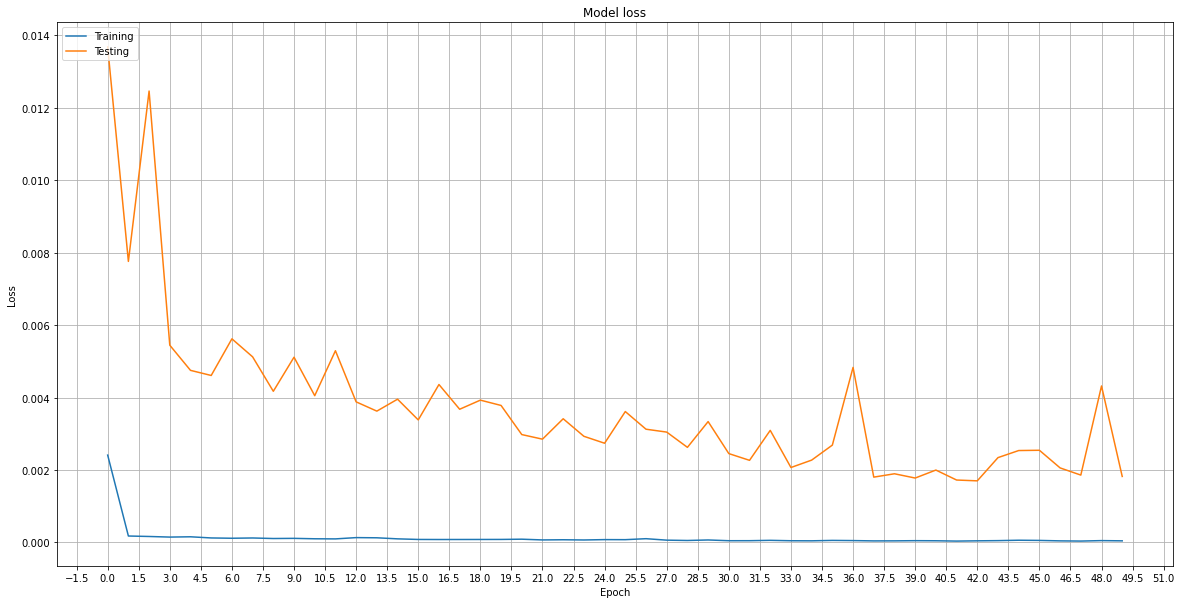

In [18]:
# Evaluate Model 1:
y_test_unscaled, y_pred = evaluate_model(model_1, x_test, y_test, scaler_pred)

# Plot training and testing loss values of model 1
history_accuracy_loss(history_1)

In [19]:
# Save the model 1
model_1.save('models/LSTM_model_1.h5') 

##### Model 2 Evaluation

R2 Score:  0.5856446686474266
Mean Absolute Error:  386.013938593795
Mean Squared Error:  257986.77587299797
Mean Absolute Percentage Error: 11.27 %


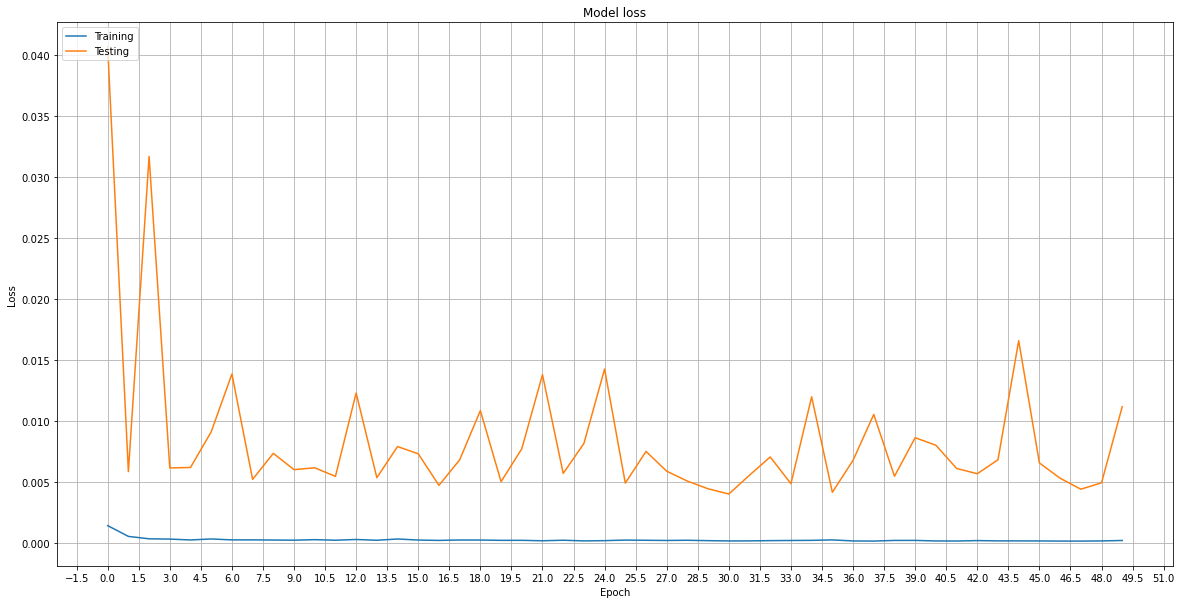

In [20]:
# Evaluate Model 2:
y_test_unscaled_2, y_pred_2 = evaluate_model(model_2, x_test, y_test, scaler_pred)

# Plot training and testing loss values of model 2
history_accuracy_loss(history_2)

In [21]:
# Save the model 2
model_2.save('models/LSTM_model_2.h5') 

### 7. Compare the Predicted and Actual Ethereum Prices

##### Model 1

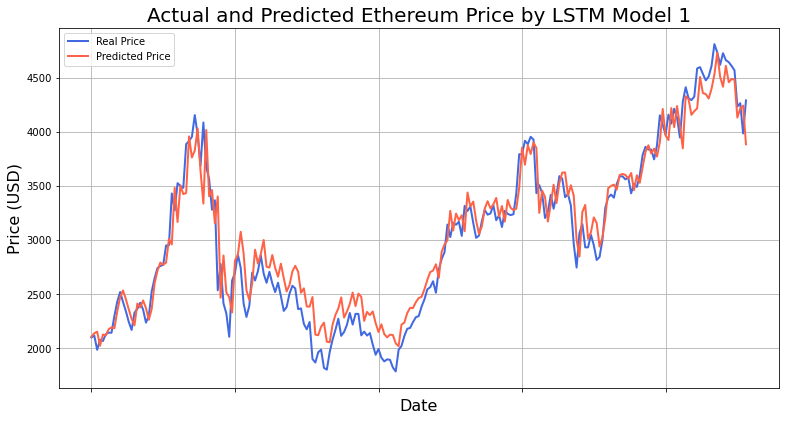

In [22]:
plot_actual_predicted(pd.DataFrame(y_test_unscaled), pd.DataFrame(y_pred), 'Actual and Predicted Ethereum Price by LSTM Model 1')

##### Model 2

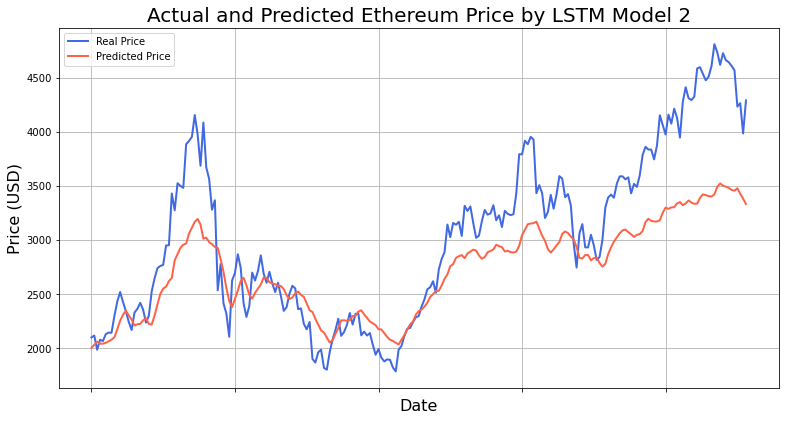

In [23]:
plot_actual_predicted(pd.DataFrame(y_test_unscaled_2), pd.DataFrame(y_pred_2), 'Actual and Predicted Ethereum Price by LSTM Model 2')

#### Conclusion:
As we can see in the evaluation session, both RNN LSTMs give the good results in Ethereum price prediction and Model 1 performs better than Model 2.

#### 8. Predict the next day's price

We trained the model with data to 19-Nov, so we will predict the Ether price on 20-Nov based on the 7 previous days (from 13-Nov to 19-Nov)

In [25]:
df_lasted = pd.read_csv('data/eth_24Nov.csv')
df_lasted[['date','PriceUSD']].tail()

,date,PriceUSD
2304,2021-11-19,4291.286350
2305,2021-11-20,4413.144251
2306,2021-11-21,4310.080434
2307,2021-11-22,4096.772401
2308,2021-11-23,4348.156228


In [47]:
# Get last 7 days
df_last_7_days = df_lasted[(df_lasted['date']<='2021-11-19') & (df_lasted['date']>='2021-11-13')]
imp_features = ['PriceUSD', 'AdrActCnt', 'AdrBal1in100MCnt',
       'AdrBal1in10BCnt', 'AdrBal1in10MCnt', 'AdrBal1in1BCnt',
       'AdrBal1in1MCnt', 'CapMrktCurUSD', 'CapRealUSD', 'DiffLast',
       'DiffMean', 'FeeMedUSD', 'FeeTotUSD', 'FlowInExUSD',
       'FlowOutExUSD', 'GasUsedTx', 'GasUsedTxMean', 'HashRate',
       'RevHashNtv', 'RevHashRateNtv', 'RevHashRateUSD',
       'SplyAdrBalUSD1M', 'TxCnt', 'TxTfrValMedUSD']

df_last_7_days = df_last_7_days[imp_features]
last_7_days_scaled = scaler.transform(df_last_7_days)

# Create an empty list and append past 7 days
X_test_new = []
X_test_new.append(last_7_days_scaled)

# Convert the X_test data set to a numpy array and reshape the data
pred_price_scaled = model_1.predict(np.array(X_test_new))
pred_price_unscaled = scaler_pred.inverse_transform(pred_price_scaled.reshape(-1, 1))

# The price of the next data (20Nov)
price_today = round(df_lasted[df_lasted['date']=='2021-11-20']['PriceUSD'],2)

# Predicted price for the next day
predicted_price = np.round(pred_price_unscaled.ravel()[0], 2)

# Calculate the difference
change_percent = round(abs(price_today - predicted_price),2)

print('The Ether price on 20 November:', price_today.values)
print('The predicted Ether price on 20 November:', predicted_price)
print('The difference is:', change_percent.values)

The Ether price on 20 November: [4413.14]
The predicted Ether price on 20 November: 4415.09
The difference is: [1.95]
